In [1]:
# ==============================================================================
# SETUP E CONFIGURAÇÃO
# ==============================================================================

# Instalação da biblioteca para fazer requisições HTTP (comunicação com a API)

# Instalação da biblioteca de API
%pip install requests

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, substring, rank
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, IntegerType
import requests

# Inicializando o Spark
spark = SparkSession.builder \
    .appName("Projeto_Nomes_IBGE") \
    .getOrCreate()

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ==============================================================================
# CAMADA BRONZE (DADOS BRUTOS / INGESTÃO)
# Objetivo: Trazer o dado para dentro do Spark exatamente como ele é na fonte.
# ==============================================================================

nomes_alvo = ["ENZO", "VALENTINA", "DANIEL", "JESSICA", "JOSE", "ANITTA"]
data_list = []

print("Buscando dados no IBGE...")
for nome in nomes_alvo:
    response = requests.get(f"https://servicodados.ibge.gov.br/api/v2/censos/nomes/{nome}")
    if response.status_code == 200:
        json_data = response.json()
        if json_data:
            data_list.append(json_data[0])

# Definimos o "mapa" (schema) dos dados para que o Spark entenda a estrutura do JSON
schema = StructType([
    StructField("nome", StringType(), True),
    StructField("res", ArrayType(
        StructType([
            StructField("periodo", StringType(), True),
            StructField("frequencia", IntegerType(), True)
        ])
    ), True)
])

# Criando a camada Bronze (dados brutos estruturados)
df_bronze = spark.createDataFrame(data_list, schema=schema)
df_bronze.show(truncate=False)

Buscando dados no IBGE...
+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|nome     |res                                                                                                                                                                                                        |
+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ENZO     |[{1930[, 21}, {[1930,1940[, 44}, {[1940,1950[, 64}, {[1950,1960[, 139}, {[1960,1970[, 188}, {[1970,1980[, 270}, {[1980,1990[, 473}, {[1990,2000[, 2088}, {[2000,2010[, 44056}]                             |
|VALENTINA|[{1930[, 389}, {[1930,1940[, 646}, {[1940,1950[, 911}, {[1950,1960[, 1003}, {[1960,1970[, 872}, {[1

In [4]:
# ==============================================================================
# CAMADA SILVER (LIMPEZA E TRANSFORMAÇÃO)
# Objetivo: Filtrar, limpar tipos de dados e deixar a tabela pronta para análise.
# ==============================================================================

# Transformamos o dado: explode transforma a lista de períodos em várias linhas
# O regexp_extract limpa o texto do período e extrai apenas o ano de início

from pyspark.sql.functions import regexp_extract, when

# Refinando a extração do ano
df_silver_v2 = df_silver_v2 = df_bronze.select(
    col("nome"),
    explode(col("res")).alias("decada")
).select(
    col("nome"),
    col("decada.frequencia").alias("frequencia"),
    # Extrai os primeiros 4 dígitos encontrados no texto do período
    regexp_extract(col("decada.periodo"), r"(\d{4})", 1).alias("ano_inicio")
).withColumn("ano_inicio", col("ano_inicio").cast("int"))

# Removendo linhas onde o ano ainda seja nulo (se houver)
df_silver_v2 = df_silver_v2.filter(col("ano_inicio").isNotNull())

df_silver_v2.orderBy("ano_inicio").show(10)

+---------+----------+----------+
|     nome|frequencia|ano_inicio|
+---------+----------+----------+
|VALENTINA|       389|      1930|
|     JOSE|    118121|      1930|
|  JESSICA|        30|      1930|
|     JOSE|    311202|      1930|
|   DANIEL|      1425|      1930|
|  JESSICA|        39|      1930|
|     ENZO|        21|      1930|
|   DANIEL|      4601|      1930|
|VALENTINA|       646|      1930|
|     ENZO|        44|      1930|
+---------+----------+----------+
only showing top 10 rows



In [5]:
# ==============================================================================
# CAMADA GOLD (NEGÓCIO E INSIGHTS)
# Objetivo: Aplicar regras de negócio (Ranking) para consumo final ou relatórios.
# ==============================================================================
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

# Definindo a "Janela": Agrupamos por década e ordenamos pela maior frequência
windowSpec = Window.partitionBy("ano_inicio").orderBy(col("frequencia").desc())

df_gold = df_silver_v2.withColumn("posicao", rank().over(windowSpec))

# Filtrando apenas o Top 3 de cada década para o relatório final
ranking_final = df_gold.filter(col("posicao") <= 3).orderBy("ano_inicio", "posicao")

print("Ranking de Popularidade por Década (Camada Gold):")
ranking_final.show(50)

Ranking de Popularidade por Década (Camada Gold):
+---------+----------+----------+-------+
|     nome|frequencia|ano_inicio|posicao|
+---------+----------+----------+-------+
|     JOSE|    311202|      1930|      1|
|     JOSE|    118121|      1930|      2|
|   DANIEL|      4601|      1930|      3|
|     JOSE|    648754|      1940|      1|
|   DANIEL|     10500|      1940|      2|
|VALENTINA|       911|      1940|      3|
|     JOSE|   1082782|      1950|      1|
|   DANIEL|     20672|      1950|      2|
|VALENTINA|      1003|      1950|      3|
|     JOSE|   1242231|      1960|      1|
|   DANIEL|     38949|      1960|      2|
|VALENTINA|       872|      1960|      3|
|     JOSE|    942212|      1970|      1|
|   DANIEL|     78204|      1970|      2|
|  JESSICA|      2569|      1970|      3|
|     JOSE|    661123|      1980|      1|
|   DANIEL|    171147|      1980|      2|
|  JESSICA|     40631|      1980|      3|
|     JOSE|    431536|      1990|      1|
|  JESSICA|    346278|    

In [12]:
# ==============================================================================
# PERSISTÊNCIA E VALIDAÇÃO
# Objetivo: Salvar o resultado final em um local permanente.
# ==============================================================================
# 1. Escolha um caminho que é nativo do container (sem sincronização com Windows)
caminho_interno = "/home/jovyan/ranking_final_teste"

# 2. Tente salvar
try:
    ranking_final.write.mode("overwrite").parquet(caminho_interno)
    print(f"✅ SUCESSO! Os dados foram salvos em: {caminho_interno}")
    
    # 3. Vamos ler os dados de volta para ter certeza que funcionou
    df_validacao = spark.read.parquet(caminho_interno)
    print(f"📊 Validação: Lidas {df_validacao.count()} linhas do arquivo salvo.")
    df_validacao.show(5)
    
except Exception as e:
    print(f"❌ Erro persistente: {e}")

✅ SUCESSO! Os dados foram salvos em: /home/jovyan/ranking_final_teste
📊 Validação: Lidas 24 linhas do arquivo salvo.
+------+----------+----------+-------+
|  nome|frequencia|ano_inicio|posicao|
+------+----------+----------+-------+
|  JOSE|    311202|      1930|      1|
|  JOSE|    118121|      1930|      2|
|DANIEL|      4601|      1930|      3|
|  JOSE|    648754|      1940|      1|
|DANIEL|     10500|      1940|      2|
+------+----------+----------+-------+
only showing top 5 rows



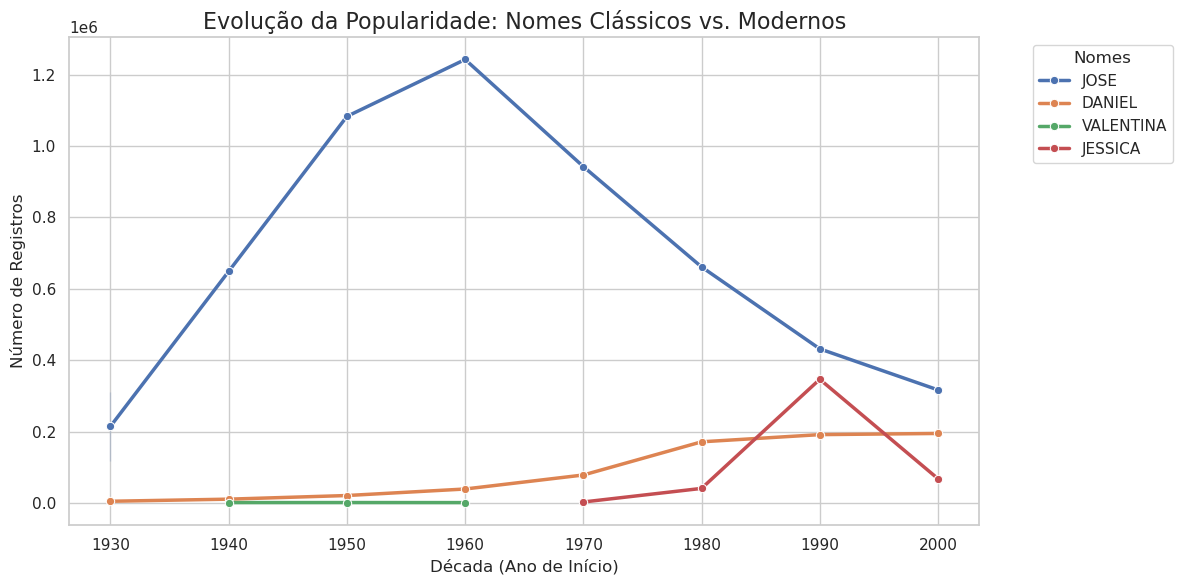

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Converter o ranking final para Pandas (já que o dado é pequeno e processado)
df_plot = ranking_final.toPandas()

# 2. Configurar o estilo do gráfico
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# 3. Criar o gráfico de linhas
plot = sns.lineplot(
    data=df_plot, 
    x="ano_inicio", 
    y="frequencia", 
    hue="nome", 
    marker="o",
    linewidth=2.5
)

# 4. Personalização
plt.title("Evolução da Popularidade: Nomes Clássicos vs. Modernos", fontsize=16)
plt.xlabel("Década (Ano de Início)", fontsize=12)
plt.ylabel("Número de Registros", fontsize=12)
plt.legend(title="Nomes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()